In [ ]:
# === importing dependencies ===#
import numpy as np
import xarray as xr
import pandas as pd
import os
import sys
import ast
import yaml

import matplotlib.pyplot as plt

from pytorch_tabnet.tab_model import TabNetRegressor
import pickle
from pickle import dump, load
import joblib

import torch

import flaml
from flaml import AutoML

from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing

#For reproducibility of the results, the following seeds should be selected 
from numpy.random import seed
randSeed = np.random.randint(1000)

if os.path.exists('/media/ssd_2tb_evo/DL_based_wind_profile_estimation'):
    root_dir = '/media/ssd_2tb_evo/DL_based_wind_profile_estimation'
elif os.path.exists('/home/harish/Ongoing_Research/DL_based_wind_profile_estimation'):
    root_dir = '/home/harish/Ongoing_Research/DL_based_wind_profile_estimation'
else:
    root_dir = '/Users/harishbaki/Ongoing_Research/DL_based_wind_profile_estimation'

sys.path.append(root_dir)
from libraries import *
from plotters import *

# === gather variables provided as input arguments ===
config_file = 'config_ERA5_to_CERRA.yaml' #sys.argv[1]
train_years = int(17) #int(sys.argv[2])
Ens = 0 #int(sys.argv[3]) #ensemble number

# === load yaml file and extract variables ===
with open(config_file, 'r') as yaml_file:
    configure = yaml.safe_load(yaml_file)
input_file = configure['input_file']
input_times_freq = configure['input_times_freq']
Coeff_file = configure['Coeff_file']
profiles_file = None if configure['profiles_file'] == '' else configure['profiles_file']
input_variables = configure['input_variables']
train_locations = configure['train_locations']
test_dates_range = configure['test_dates_range']
test_locations = configure['test_locations']
nEns = configure['nEns']
tabnet_param_file = configure['tabnet_param_file']
target_variables = configure['target_variables']
experiment = configure['experiment']

In [4]:
test_dates_range

['2017-03-24T00:00:00', '2018-04-11T23:00:00']

In [5]:
# profle: best fit date, worst fit date
profile_dates = {'High shear': ['2017-10-17T03:00:00','2017-06-06T10:00:00'],
                'Low shear/well mixed':['2017-05-10T12:00:00','2017-11-20T13:00:00'],
                'LLJ': ['2018-04-10T03:00:00','2017-03-30T02:00:00'],
                'High wind': ['2017-12-31T12:00:00','2018-01-05T04:00:00'],
                }
text_locs = [[0.6, 0.95],[0.6, 0.95],[0.6, 0.95],[0.05, 0.95],[0.05, 0.95],[0.6, 0.95]]

In [6]:
for run,year in enumerate(np.arange(2000,2017+1-train_years)):
    train_dates_range = [str(year)+'-01-01',str(year+train_years-1)+'-12-31']
    print(run,train_dates_range)

    # === training and validation data parameters ===#
    X_train,Y_train, X_valid,Y_valid = data_processing(input_file,Coeff_file,input_times_freq,
                                                       input_variables,target_variables,train_dates_range,train_locations,val_arg=True,
                                                       profiles_file=profiles_file,threshold=2)
    print('training inputs shape:',X_train.shape,'training targets shape:',Y_train.shape,'validation inputs shape:',X_valid.shape,'validation targets shape:',Y_valid.shape)

0 ['2000-01-01', '2016-12-31']
training inputs shape: (110100, 24) training targets shape: (110100, 5) validation inputs shape: (27055, 24) validation targets shape: (27055, 5)


In [7]:
import pandas as pd

# Define the start and end dates
start_date = pd.Timestamp('2000-01-01')
end_date = pd.Timestamp('2016-12-31')

# Calculate the number of hours between the dates
hours_between = (end_date - start_date).total_seconds() / 3600

print("Number of hours between 2000 Jan 1 and 2016 Dec 31:", hours_between)


Number of hours between 2000 Jan 1 and 2016 Dec 31: 149016.0


### Simple AutoML xgboost regresison or lgbm
- Experimented with xgboost, but the performance is quite unsatisfactory

In [8]:
automl_settings = {
    "time_budget": 3600,  # in seconds
    "metric": 'rmse',
    "task": 'regression',
    "estimator_list": ['xgboost'],
    "early_stop": True,
    "model_history": True, #A boolean of whether to keep the best model per estimator
    "retrain_full": True, #whether to retrain the selected model on the full training data
}

In [9]:
trained_models = {}
# === Target variables ===#
target_variables = [0,1] #represent coefficients from 0 to 4
for i,target_variable in enumerate(target_variables):
    # === initialize automl regressor ===#
    automl = AutoML()
    # === Train AUTOML regressor ===#
    X_tr,y_tr,X_val,y_val = np.hstack([X_train,Y_train[:,0:i]]), Y_train[:,i:i+1], np.hstack([X_valid,Y_valid[:,0:i]]), Y_valid[:,i:i+1]
    print(X_tr.shape,y_tr.shape,X_val.shape,y_val.shape)

    automl.fit(X_train=X_tr, y_train = y_tr,X_val=X_val, y_val=y_val, **automl_settings)

    # === save the model ===#
    trained_models[f'Coefficient_{target_variable}'] = automl

(110100, 24) (110100, 1) (27055, 24) (27055, 1)
[flaml.automl.logger: 02-14 10:38:54] {1728} INFO - task = regression
[flaml.automl.logger: 02-14 10:38:54] {1736} INFO - Data split method: uniform
[flaml.automl.logger: 02-14 10:38:54] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 02-14 10:38:54] {1838} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 02-14 10:38:54] {1955} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 02-14 10:38:54] {2258} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 02-14 10:38:54] {2393} INFO - Estimated sufficient time budget=16861s. Estimated necessary time budget=17s.
[flaml.automl.logger: 02-14 10:38:54] {2442} INFO -  at 0.2s,	estimator xgboost's best error=3.4728,	best estimator xgboost's best error=3.4728
[flaml.automl.logger: 02-14 10:38:54] {2258} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 02-14 10:38:54] {2442} INFO -  at 0.2s,	estimator xgboost's best erro

In [11]:
# === testing data parameters ===#
X_test,Y_test = data_processing(input_file,Coeff_file,input_times_freq,input_variables,target_variables,test_dates_range,test_locations)
print('testing inputs shape:',X_test.shape,'testing targets shape:',Y_test.shape)

testing inputs shape: (9216, 24) testing targets shape: (9216, 2)


(9216, 24) (9216, 1)
(9216, 1)
(9216, 25) (9216, 1)
(9216, 2)


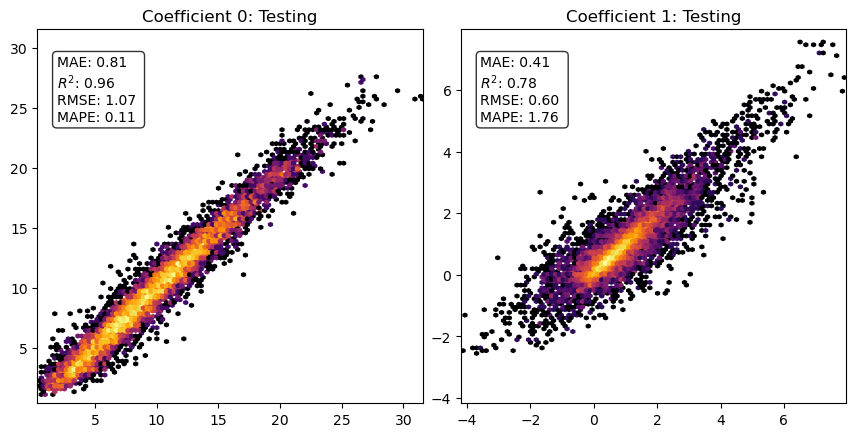

In [12]:
fig = plt.figure(figsize=(20, 8), constrained_layout=True)
gs = fig.add_gridspec(2,5)

Y_pred = []
for i,target_variable in enumerate(target_variables):
    X_te = X_test if i==0 else np.hstack([X_test,Y_pred])
    y_te = Y_test[:,i:i+1]
    print(X_te.shape,y_te.shape)
    y_pred = trained_models[f'Coefficient_{target_variable}'].predict(X_te)
    y_pred = y_pred.reshape(-1,1)
    Y_pred = np.hstack([Y_pred,y_pred]) if i>0 else y_pred
    print(Y_pred.shape)
    hexbin_plotter(fig,gs[0,i],y_te,y_pred,f'Coefficient {target_variable}: Testing',text_arg=True)

#plt.savefig(f'Figures/single_output_lgbm_CERRA_targets_coefficients_hexbin_plot.png',dpi=300)

In [70]:
CERRA_levels = [10., 15., 30., 50., 75., 100., 150., 200., 250., 300., 400., 500.]
ERA5_levels = [10, 100]
def profle_plotter(fig,gs,X_test,Y_test,ERA5_ws=None,Obs=None,date=None,title=None,xlabel=None,ylabel=None,train_years=None,run=None,experiment=experiment):
    axs = fig.add_subplot(gs)
    
    # plot ERA5 10m and 100m wind speeds
    ERA5_ws = X_test[0,0:2] if ERA5_ws is None else ERA5_ws
    axs.plot(ERA5_ws, ERA5_levels, 'dg', markerfacecolor='g', label='ERA5')

    # Calculate observed profile
    M_true = WindProfile(Z, Y_test[0,:])
    axs.plot(M_true, Z, '-k', linewidth=2, markerfacecolor='r', label='CERRA')

    Mp = WindProfile(Z, Y_pred[0,:])

    # Plot Mp
    axs.plot(Mp, Z, linestyle='-', linewidth=2, label='XGBoost', markerfacecolor='b')

    axs.set_xlim([0, 30])
    axs.set_ylim([0, 500])

    if title is not None:
        axs.set_title(title)

    if xlabel is not None:
        axs.set_xlabel(xlabel)
    if not xlabel:
        axs.xaxis.set_ticks([])
    
    if ylabel is not None:
        axs.set_ylabel(ylabel)
    if not ylabel:
        axs.yaxis.set_ticks([])
    
    return axs

### Best profiles

High shear 2017-10-17T03:00:00
(1, 24) (1, 1)
(1, 25) (1, 1)
(1, 26) (1, 1)
(1, 27) (1, 1)
(1, 28) (1, 1)
[[15.33193417  2.66993037 -0.4646765   0.2663663  -0.16420136]] [[17.394577    3.2804763  -0.49788284  0.23732015 -0.22472546]]
Low shear/well mixed 2017-05-10T12:00:00
(1, 24) (1, 1)
(1, 25) (1, 1)
(1, 26) (1, 1)
(1, 27) (1, 1)
(1, 28) (1, 1)
[[ 8.10765582  0.26359341 -0.31311313  0.07156121 -0.08741899]] [[ 5.7665677   0.03020419 -0.22581547  0.05386383 -0.05209039]]
LLJ 2018-04-10T03:00:00
(1, 24) (1, 1)
(1, 25) (1, 1)
(1, 26) (1, 1)
(1, 27) (1, 1)
(1, 28) (1, 1)
[[16.30681198 -0.92800532 -3.06863109  2.00501678  0.58292493]] [[16.789831    1.3086097  -3.0855322   1.1015856   0.17225647]]
High wind 2017-12-31T12:00:00
(1, 24) (1, 1)
(1, 25) (1, 1)
(1, 26) (1, 1)
(1, 27) (1, 1)
(1, 28) (1, 1)
[[25.19863715  6.94316462 -0.8350925   0.22094535 -0.32442423]] [[23.211786    5.8963847  -0.972732    0.26566154 -0.19198787]]


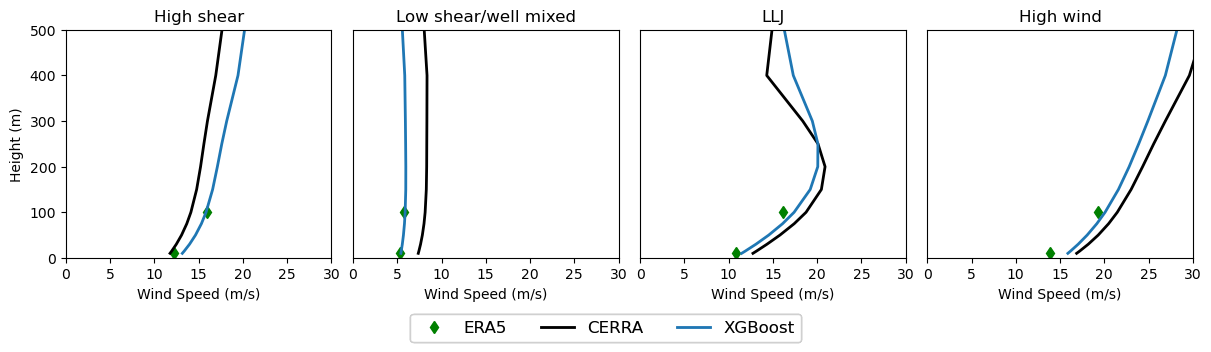

In [71]:
fig = plt.figure(figsize=(12, 3), constrained_layout=True)
gs = fig.add_gridspec(1,4)

for k,profile in enumerate(profile_dates):
    print(profile, profile_dates[profile][0])

    X_test,Y_test = data_processing(input_file,Coeff_file,input_times_freq,input_variables,target_variables,
                                    [profile_dates[profile][0],profile_dates[profile][0]],test_locations)
    Y_pred = []
    for i,target_variable in enumerate(target_variables):
        X_te = X_test if i==0 else np.hstack([X_test,Y_pred])
        y_te = Y_test[:,i:i+1]
        print(X_te.shape,y_te.shape)
        y_pred = trained_models[f'Coefficient_{target_variable}'].predict(X_te)
        y_pred = y_pred.reshape(-1,1)
        Y_pred = np.hstack([Y_pred,y_pred]) if i>0 else y_pred
    print(Y_test,Y_pred)

    title = profile
    xlabel = f'Wind Speed (m/s)'
    ylabel = f'Height (m)' if k == 0 else None
    axs = profle_plotter(fig,gs[0,k],X_test,Y_test,title=title,xlabel=xlabel,ylabel=ylabel)

    # Extract legend from one of the subplots
    handles, labels = axs.get_legend_handles_labels()
    # Create a common legend below the figures
    fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.15),fontsize=12)

### Worst profiles

High shear 2017-10-17T03:00:00
(1, 24) (1, 1)
(1, 25) (1, 1)
(1, 26) (1, 1)
(1, 27) (1, 1)
(1, 28) (1, 1)
[[11.78586933  3.12908084 -1.07249947  0.5101237  -0.25783733]] [[12.902571    2.351329   -1.2324978   0.59499484 -0.17945622]]
Low shear/well mixed 2017-05-10T12:00:00
(1, 24) (1, 1)
(1, 25) (1, 1)
(1, 26) (1, 1)
(1, 27) (1, 1)
(1, 28) (1, 1)
[[ 8.14243791 -0.49439757 -0.3273842   0.15240983 -0.06442316]] [[ 8.527622   -0.11526188 -0.33265206  0.06324326 -0.09111983]]
LLJ 2018-04-10T03:00:00
(1, 24) (1, 1)
(1, 25) (1, 1)
(1, 26) (1, 1)
(1, 27) (1, 1)
(1, 28) (1, 1)
[[11.72834649  1.36331515 -1.93451881  0.62355557 -0.06616989]] [[10.148768    0.37219414 -1.5259284   0.88964295 -0.19915001]]
High wind 2017-12-31T12:00:00
(1, 24) (1, 1)
(1, 25) (1, 1)
(1, 26) (1, 1)
(1, 27) (1, 1)
(1, 28) (1, 1)
[[17.22867019  1.64469646 -0.96622431  0.07870711 -0.19200856]] [[12.528625    1.379431   -0.5808614   0.22736546 -0.14494883]]


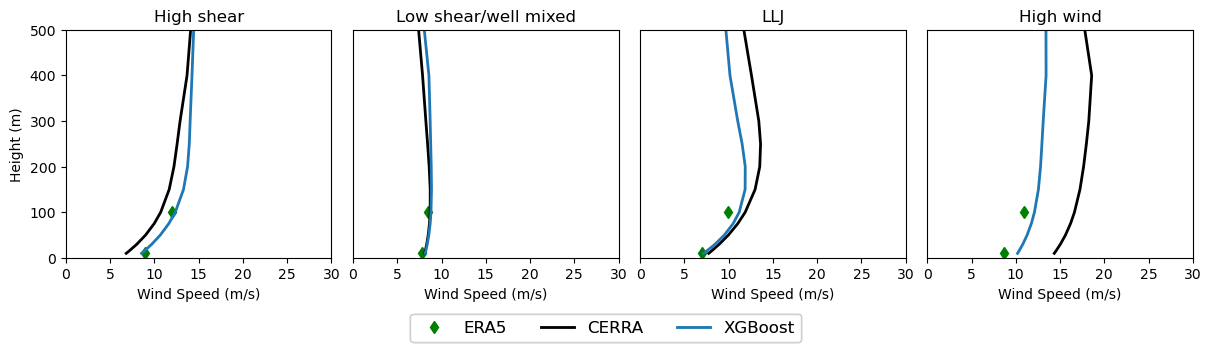

In [73]:
fig = plt.figure(figsize=(12, 3), constrained_layout=True)
gs = fig.add_gridspec(1,4)

for k,profile in enumerate(profile_dates):
    print(profile, profile_dates[profile][0])

    X_test,Y_test = data_processing(input_file,Coeff_file,input_times_freq,input_variables,target_variables,
                                    [profile_dates[profile][1],profile_dates[profile][1]],test_locations)
    Y_pred = []
    for i,target_variable in enumerate(target_variables):
        X_te = X_test if i==0 else np.hstack([X_test,Y_pred])
        y_te = Y_test[:,i:i+1]
        print(X_te.shape,y_te.shape)
        y_pred = trained_models[f'Coefficient_{target_variable}'].predict(X_te)
        y_pred = y_pred.reshape(-1,1)
        Y_pred = np.hstack([Y_pred,y_pred]) if i>0 else y_pred
    print(Y_test,Y_pred)

    title = profile
    xlabel = f'Wind Speed (m/s)'
    ylabel = f'Height (m)' if k == 0 else None
    axs = profle_plotter(fig,gs[0,k],X_test,Y_test,title=title,xlabel=xlabel,ylabel=ylabel)

    # Extract legend from one of the subplots
    handles, labels = axs.get_legend_handles_labels()
    # Create a common legend below the figures
    fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.15),fontsize=12)